In [39]:

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F

import os
import shutil
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image


In [40]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("asadullahgalib/guava-disease-dataset")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/asadullahgalib/guava-disease-dataset/versions/6


In [41]:
# Define data transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create datasets
train_dataset = torchvision.datasets.ImageFolder(root=os.path.join(path, 'GuavaDiseaseDataset/GuavaDiseaseDataset/train'), transform=transform)
test_dataset = torchvision.datasets.ImageFolder(root=os.path.join(path, 'GuavaDiseaseDataset/GuavaDiseaseDataset/test'), transform=transform)
val_dataset = torchvision.datasets.ImageFolder(root=os.path.join(path, 'GuavaDiseaseDataset/GuavaDiseaseDataset/val'), transform=transform)

# Create data loaders
train_dl = data.DataLoader(train_dataset, batch_size=5, shuffle=True)
test_dl = data.DataLoader(test_dataset, batch_size=5, shuffle=False)
val_dl = data.DataLoader(test_dataset, batch_size=5, shuffle=False)

In [42]:
len_train = len(train_dataset)
len_test = len(test_dataset)
len_val = len(val_dataset)
print(f"Number of samples train: {len_train}")
print(f"Number of samples test: {len_test}")
print(f"Number of samples val: {len_val}")

Number of samples train: 2647
Number of samples test: 382
Number of samples val: 755


In [43]:
def denormalize(images, means, stds):
    if len(images.shape) == 3:
        images = images.unsqueeze(0)
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

# Define imagenet_stats here
imagenet_stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

def show_image(img_tensor, label):
    print('Label:', train_dataset.classes[label], '(' + str(label) + ')')
    img_tensor = denormalize(img_tensor, *imagenet_stats)[0].permute((1, 2, 0))
    plt.imshow(img_tensor)

Label: Anthracnose (0)


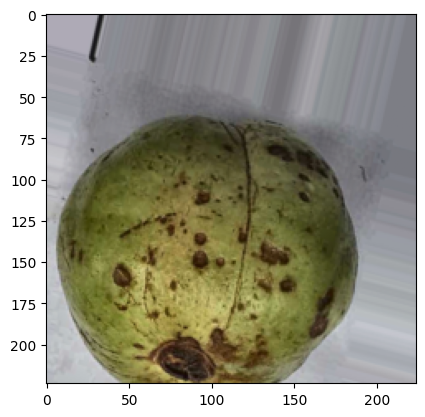

In [44]:
show_image(*train_dataset[2])

In [45]:
from torch.utils.data import random_split

In [46]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(16, 16))
        ax.set_xticks([]); ax.set_yticks([])
        images = denormalize(images[:64], *imagenet_stats)
        ax.imshow(make_grid(images, nrow=8).permute(1, 2, 0))
        break

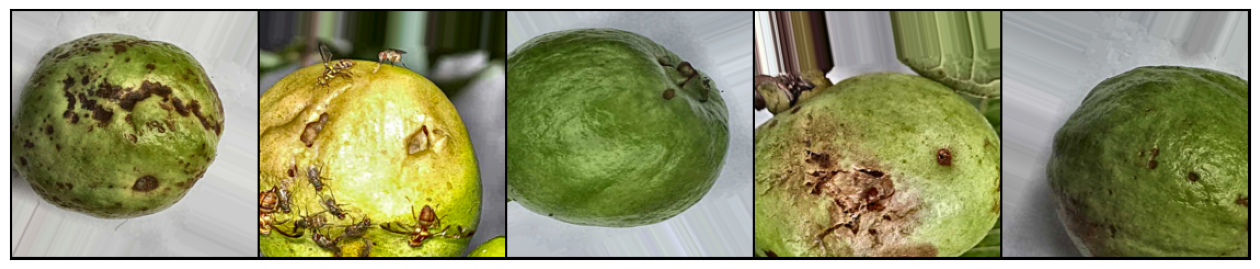

In [47]:
show_batch(train_dl)

In [48]:
import torch.nn as nn
import torch.nn.functional as F

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels)  # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}],{} train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, "last_lr: {:.5f},".format(result['lrs'][-1]) if 'lrs' in result else '',
            result['train_loss'], result['val_loss'], result['val_acc']))

    @torch.no_grad()
    def evaluate(self,val_loader):
      self.eval()
      outputs = [self.validation_step(batch) for batch in val_loader]
      return self.validation_epoch_end(outputs)

In [49]:
from torchvision import models

class PetsModel(ImageClassificationBase):
    def __init__(self, num_classes, pretrained=True):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet34(pretrained=pretrained)
        # Replace last layer
        self.network.fc = nn.Linear(self.network.fc.in_features, num_classes)

    def forward(self, xb):
        return self.network(xb)

In [50]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')


def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)


class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""

    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [51]:
import torch
from tqdm.notebook import tqdm


def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = model.evaluate(val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader,
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []

    # Set up custom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs,
                                                steps_per_epoch=len(train_loader))

    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            # Gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()

        # Validation phase
        result = model.evaluate(val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [52]:
device = get_default_device()
device

device(type='cuda')

In [53]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(val_dl, device)

In [54]:
model = PetsModel(len(train_dataset.classes))
to_device(model, device);

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [55]:
history = [model.evaluate(valid_dl)]
history

[{'val_loss': 1.201431155204773, 'val_acc': 0.3610389828681946}]

In [56]:
epochs = 6
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [57]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl,
                         grad_clip=grad_clip,
                         weight_decay=weight_decay,
                         opt_func=opt_func)

  0%|          | 0/530 [00:00<?, ?it/s]

Epoch [0],last_lr: 0.00603, train_loss: 0.6653, val_loss: 0.4274, val_acc: 0.8338


  0%|          | 0/530 [00:00<?, ?it/s]

Epoch [1],last_lr: 0.00994, train_loss: 0.6175, val_loss: 0.7512, val_acc: 0.6935


  0%|          | 0/530 [00:00<?, ?it/s]

Epoch [2],last_lr: 0.00812, train_loss: 0.4422, val_loss: 0.2509, val_acc: 0.9117


  0%|          | 0/530 [00:00<?, ?it/s]

Epoch [3],last_lr: 0.00463, train_loss: 0.3057, val_loss: 0.1796, val_acc: 0.9377


  0%|          | 0/530 [00:00<?, ?it/s]

Epoch [4],last_lr: 0.00133, train_loss: 0.2591, val_loss: 0.1099, val_acc: 0.9610


  0%|          | 0/530 [00:00<?, ?it/s]

Epoch [5],last_lr: 0.00000, train_loss: 0.1565, val_loss: 0.0890, val_acc: 0.9636
CPU times: user 3min 58s, sys: 4.41 s, total: 4min 2s
Wall time: 4min 7s


In [58]:
model2 = PetsModel(len(train_dataset.classes), pretrained=False)
to_device(model2, device);

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [59]:
history2 = [model2.evaluate(valid_dl)]
history2

[{'val_loss': 36.95298767089844, 'val_acc': 0.40519481897354126}]

In [60]:
%%time
history2 += fit_one_cycle(epochs, max_lr, model2, train_dl, valid_dl,
                         grad_clip=grad_clip,
                         weight_decay=weight_decay,
                         opt_func=opt_func)

  0%|          | 0/530 [00:00<?, ?it/s]

Epoch [0],last_lr: 0.00603, train_loss: 0.8774, val_loss: 2.0357, val_acc: 0.6987


  0%|          | 0/530 [00:00<?, ?it/s]

Epoch [1],last_lr: 0.00994, train_loss: 0.7447, val_loss: 1.5675, val_acc: 0.7532


  0%|          | 0/530 [00:00<?, ?it/s]

Epoch [2],last_lr: 0.00812, train_loss: 0.6013, val_loss: 0.3842, val_acc: 0.8675


  0%|          | 0/530 [00:00<?, ?it/s]

Epoch [3],last_lr: 0.00463, train_loss: 0.5279, val_loss: 0.3489, val_acc: 0.9013


  0%|          | 0/530 [00:00<?, ?it/s]

Epoch [4],last_lr: 0.00133, train_loss: 0.3815, val_loss: 0.2901, val_acc: 0.9169


  0%|          | 0/530 [00:00<?, ?it/s]

Epoch [5],last_lr: 0.00000, train_loss: 0.2771, val_loss: 0.2074, val_acc: 0.9351
CPU times: user 3min 57s, sys: 4.46 s, total: 4min 2s
Wall time: 4min 6s


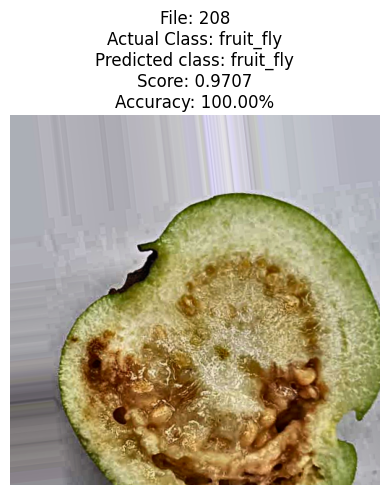

In [61]:

def predict_image(image_path, image_index=None):
    model.eval()
    img = Image.open(image_path).convert('RGB')
    img_transform = transform(img).unsqueeze(0)

    img_transform = img_transform.to(device)

    with torch.no_grad():
        pred = model(img_transform)

    _,pred_class_indx = torch.max(pred,1)
    class_labels = list(test_dl.dataset.class_to_idx.keys())
    pred_class_label = class_labels[pred_class_indx.item()]

    pred_score = torch.softmax(pred,dim=1)[0][pred_class_indx].item()

    if image_index is not None:
        return pred_class_label, pred_score, image_index, img
    else:
        return pred_class_label, pred_score, image_path, img

# Get a random image index from the test dataset
random_index = random.randint(0, len(test_dataset) - 1)

# Get the image path and actual label using the random index
image_file, actual_label = test_dataset.imgs[random_index]


# Make prediction and get file number
predicted_label, predicted_score, file_info, img = predict_image(image_file, random_index)

# Calculate accuracy
accuracy = (predicted_label == train_dataset.classes[actual_label]) * 100 # compare with actual label


# Display the image
plt.imshow(img)
plt.title(f"File: {file_info}\nActual Class: {train_dataset.classes[actual_label]}\nPredicted class: {predicted_label}\nScore: {predicted_score:.4f}\nAccuracy: {accuracy:.2f}%")
plt.axis('off')
plt.show()

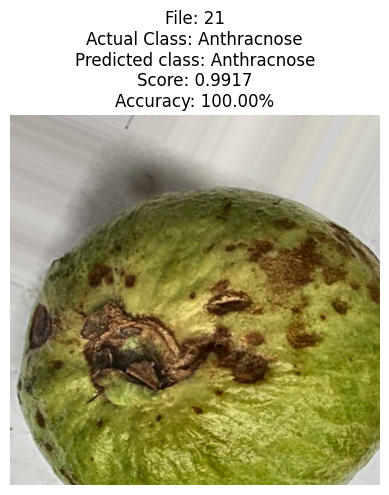

In [62]:

def predict_image(image_path, image_index=None, model = model2):
    model.eval()
    img = Image.open(image_path).convert('RGB')
    img_transform = transform(img).unsqueeze(0)

    img_transform = img_transform.to(device)

    with torch.no_grad():
        pred = model(img_transform)

    _,pred_class_indx = torch.max(pred,1)
    class_labels = list(test_dl.dataset.class_to_idx.keys())
    pred_class_label = class_labels[pred_class_indx.item()]

    pred_score = torch.softmax(pred,dim=1)[0][pred_class_indx].item()

    if image_index is not None:
        return pred_class_label, pred_score, image_index, img
    else:
        return pred_class_label, pred_score, image_path, img

# Get a random image index from the test dataset
random_index = random.randint(0, len(test_dataset) - 1)

# Get the image path and actual label using the random index
image_file, actual_label = test_dataset.imgs[random_index]


# Make prediction and get file number
predicted_label, predicted_score, file_info, img = predict_image(image_file, random_index)

# Calculate accuracy
accuracy = (predicted_label == train_dataset.classes[actual_label]) * 100 # compare with actual label


# Display the image
plt.imshow(img)
plt.title(f"File: {file_info}\nActual Class: {train_dataset.classes[actual_label]}\nPredicted class: {predicted_label}\nScore: {predicted_score:.4f}\nAccuracy: {accuracy:.2f}%")
plt.axis('off')
plt.show()